# 09-04 네거티브 샘플링을 이용한 Word2Vec 구현(Skip-Gram with Negative Sampling, SGNS)

## 네거티브 샘플링(Negative Sampling)

Word2Vec의 출력층에서는 소프트맥스 함수를 지난 단어 집합 크기의 벡터와 실제값인 원-핫 벡터와의 오차를 구하고 이로부터 임베딩 테이블에 있는 모든 단어에 대한 임베딩 벡터 값을 업데이트합니다.  
Word2Vec은 역전파 과정에서 모든 단어의 임베딩 벡터값의 업데이트를 수행하지만, 만약 현재 집중하고 있는 중심 단어와 주변 단어가 '강아지'와 '고양이', '귀여운'과 같은 단어라면, 사실 이 단어들과 별 연관 관계가 없는 '돈가스'나 '컴퓨터'와 같은 수많은 단어의 임베딩 벡터값까지 업데이트하는 것은 비효율적입니다.  
네거티브 샘플링은 Word2Vec이 학습 과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중할 수 있도록 하는 방법입니다. 가령, 현재 집중하고 있는 주변 단어가 '고양이', '귀여운'이라고 해봅시다. 여기에 '돈가스', '컴퓨터', '회의실'과 같은 단어 집합에서 무작위로 선택된 주변 단어가 아닌 단어들을 일부 가져옵니다. 이렇게 하나의 중심 단어에 대해서 전체 단어 집합보다 훨씬 작은 단어 집합을 만들어놓고 마지막 단계를 이진 분류 문제로 변환합니다. 주변 단어들을 긍정(positive), 랜덤으로 샘플링 된 단어들을 부정(negative)으로 레이블링한다면 이진 분류 문제를 위한 데이터셋이 됩니다. 이는 기존의 단어 집합의 크기만큼의 선택지를 두고 다중 클래스 분류 문제를 풀던 Word2Vec보다 훨씬 연산량에서 효율적입니다.

## 네거티브 샘플링 Skip-Gram(Skip-Gram with Negative Sampling, SGNS)

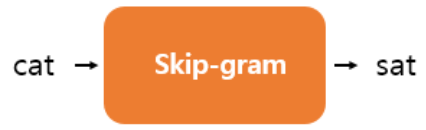  
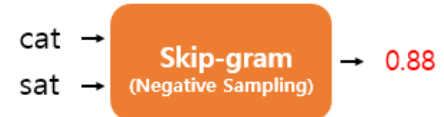  
Skip-gram(Skip-Gram with Negative Sampling, SGNS): 기존의 Skip-gram 모델과 다르게 중심 단어와 주변 단어가 모두 입력이 되고, 이 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지 그 확률을 예측

기존의 Skip-gram 데이터셋을 SGNS의 데이터셋으로 바꾸는 과정  
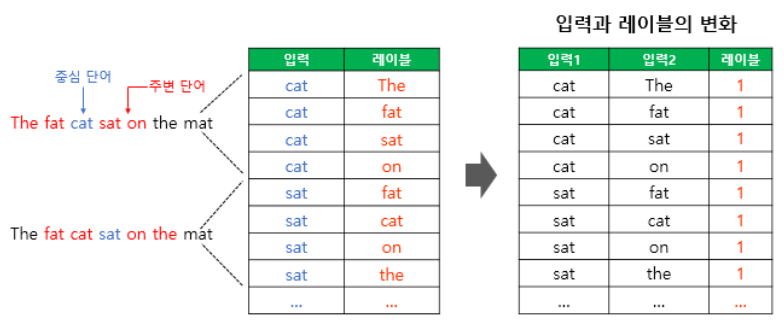  
단어 집합에서 랜덤으로 선택한 단어들을 입력2로 하고, 레이블을 0으로 합니다. 이제 이 데이터셋은 입력1과 입력2가 실제로 윈도우 크기 내에서 이웃 관계인 경우에는 레이블이 1, 아닌 경우에는 레이블이 0인 데이터셋이 됩니다.  
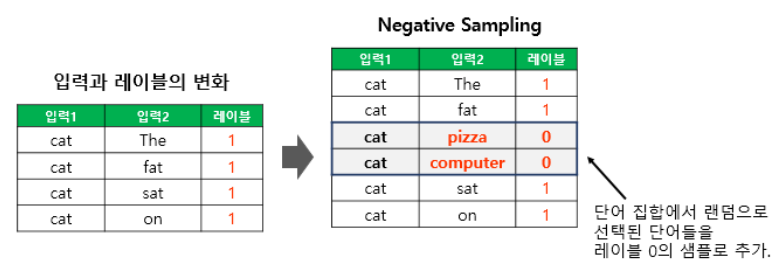  
두 테이블 중 하나는 입력 1인 중심 단어의 테이블 룩업을 위한 임베딩 테이블이고, 하나는 입력 2인 주변 단어의 테이블 룩업을 위한 임베딩 테이블입니다.(두 임베딩 테이블은 훈련 데이터의 단어 집합의 크기를 가지므로 크기가 같습니다.) 각 단어는 각 임베딩 테이블을 테이블 룩업하여 임베딩 벡터로 변환됩니다.  
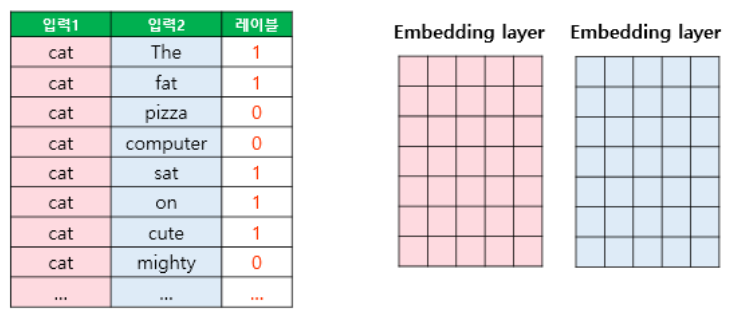  
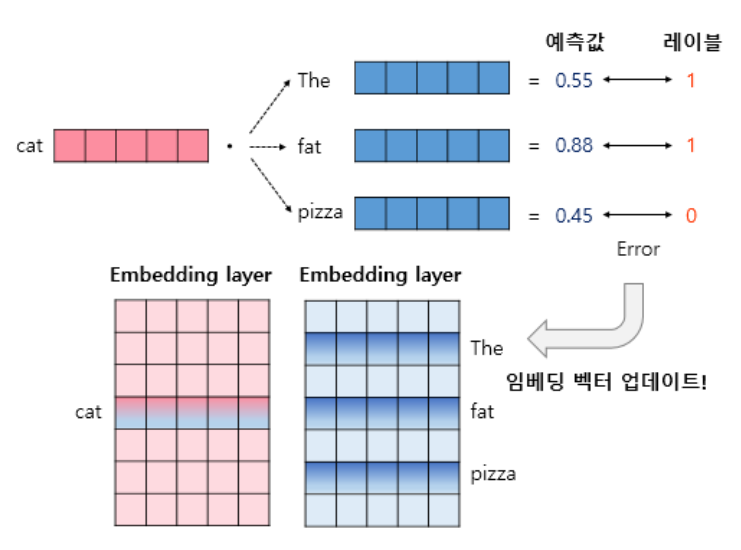

## 20뉴스그룹 데이터 전처리하기

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [2]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join(w for w in x.split() if len(w)>3))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

C:\Users\82105\AppData\Local\Temp\ipykernel_85324\2082043459.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [3]:
news_df.isnull().values.any()

False

In [4]:
# 모든 빈 값을 Null 값으로 변환하고, 다시 Null 값이 있는지 확인
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [5]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [6]:
# 불용어를 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [7]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


c:\Users\82105\anaconda3\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [9]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [10]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


## 네거티브 샘플링을 통한 데이터셋 구성하기

In [11]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [12]:
# 10개의 뉴스그룹 샘플에 대해서 모두 수행되었지만, 첫번째 뉴스그룹 샘플에 대해서만 확인
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(media (702), focke (60785)) -> 0
(letter (705), incidences (20294)) -> 1
(shame (4988), daily (1920)) -> 1
(story (603), israels (13686)) -> 1
(daily (1920), yvjju (38494)) -> 0


In [13]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [14]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


In [15]:
# 이 작업을 모든 뉴스그룹 샘플에 대해서 수행
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

## Skip-Gram with Negative Sampling(SGNS) 구현하기

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이며 각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고, 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 얻습니다.

In [23]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       6427700     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       6427700     ['input_2[0][0]']                
                                                                                            

모델의 학습은 5에포크 수행하겠습니다.

In [27]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

## 결과 확인하기

학습된 임베딩 벡터들을 vector.txt에 저장합니다. 그 후 이를 gensim의 models.KeyedVectors.load_word2vec_format()으로 로드하면 쉽게 단어 벡터 간 유사도를 구할 수 있습니다.

In [ ]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['soldiers'])